In [1]:
'''
This notebook depicts the results of a bayesian sequence model trained on s0, {a0...aT} -> s' examples. Liklihood std=0.01
time standardization is used for preprocessing. 
MACHINE: tesla
MODEL ID: 3sisbivl
Preprocessing: Time standardization
'''

"\nThis notebook depicts the results of a bayesian sequence model trained on s0, {a0...aT} -> s' examples. Liklihood std=0.01\ntime standardization is used for preprocessing. \nMACHINE: tesla\nMODEL ID: 3sisbivl\nPreprocessing: Time standardization\n"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import os
import torch
import time

import pyro
import pyro.optim as optim
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO

from bayesian_rnn_without_bias import BayesianSequenceModel
from utils.visualize import *
from utils.tools import *
import wandb

In [4]:
machine = "honshu"
notes = "attempting {a0...aT} input as opposed to {(s0,a0)...(sT,aT)} input, more expressive network"
name = "likelihood_std=0.01+time_standardization"

# wandb.init(project="bayesian_sequence_modelling", name=machine+"/"+name, tags=[machine], notes=notes, reinit=True)

root = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = root+"/../datasets/vanilla_rnn"
X_train, A_train, Y_train = np.load(dataset+"/train/states.npy"), np.load(dataset+"/train/actions.npy"), np.load(dataset+"/train/next_states.npy")
X_val, A_val, Y_val = np.load(dataset+"/val/states.npy"), np.load(dataset+"/val/actions.npy"), np.load(dataset+"/val/next_states.npy")
X_test, A_test, Y_test = np.load(dataset+"/test/states.npy"), np.load(dataset+"/test/actions.npy"), np.load(dataset+"/test/next_states.npy")

X_train, Y_train = standardize_across_time(X_train), standardize_across_time(Y_train) 
X_val, Y_val = standardize_across_time(X_val), standardize_across_time(Y_val) 
X_test, Y_test = standardize_across_time(X_test), standardize_across_time(Y_test) 

# X_train, Y_train = standardize_across_samples(X_train), standardize_across_samples(Y_train) 
# X_val, Y_val = standardize_across_samples(X_val), standardize_across_samples(Y_val) 
# X_test, Y_test = standardize_across_samples(X_test), standardize_across_samples(Y_test) 

config = {
    "dataset"           :   dataset,
    "state_size"        :   X_train.shape[-1],
    "action_size"       :   A_train.shape[-1],
    "z_size"            :   128,
    "hidden_state_size" :   512,
    "likelihood_std"    :   0.01,
    "epochs"            :   50,
    "batch_size"        :   1600,
    "learning_rate"     :   1.0e-3,
    "device"            :   device,
    "preprocessing"     :   "standardization across batch"
}

In [5]:
vrnn = BayesianSequenceModel(state_size=config["state_size"], 
                             action_size=config["action_size"], 
                             z_size=config["z_size"], 
                             hidden_state_size=config["hidden_state_size"], 
                             likelihood_std=config["likelihood_std"],
                             device=device,
                             path=root+"/wandb/run-20200415_233445-3sisbivl/tesla_likelihood_std=0.01+time_standardization_bayesian_rnn_model_without_bias.pth").to(device)

In [6]:
vrnn.load_checkpoint()

In [7]:
X_train=torch.from_numpy(X_train[:]).to(device)
A_train=torch.from_numpy(A_train[:]).to(device)
Y_train=torch.from_numpy(Y_train[:]).to(device)

X_val=torch.from_numpy(X_val[:]).to(device)
A_val=torch.from_numpy(A_val[:]).to(device)
Y_val=torch.from_numpy(Y_val[:]).to(device)

X_test=torch.from_numpy(X_test[:]).to(device)
A_test=torch.from_numpy(A_test[:]).to(device)
Y_test=torch.from_numpy(Y_test[:]).to(device)

In [8]:
# PREDICTION WITHOUT UNCERTAINTY ESTIMATES

In [228]:
n = 0
Y_hat, O = vrnn.predict(x=X_test[n:n+1, 0:1, :], A=A_test[n:n+1, :, :], Y=Y_test[n:n+1, :, :])

In [229]:
Y_hat.shape

(1, 100, 21)

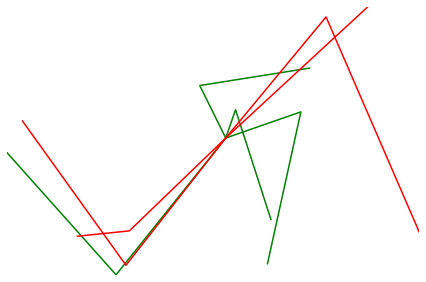

<Figure size 432x288 with 0 Axes>

In [11]:
compare_states(Y=Y_test[n], Y_hat=Y_hat[0], overlap=True)            # animation of joints

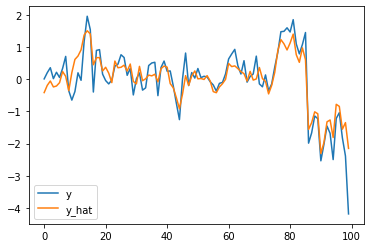

In [230]:
# VELOCITIES
plot_velocity_curve(true=Y_test[0, :, 0].data.cpu().numpy(), pred=Y_hat[0, :, 0]) # x-velocity

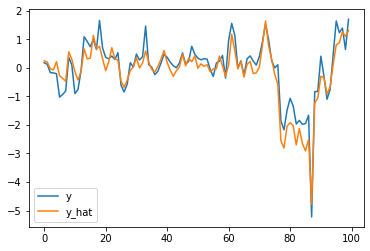

In [231]:
plot_velocity_curve(true=Y_test[n, :, 1].data.cpu().numpy(), pred=Y_hat[0, :, 1]) # y-velocity

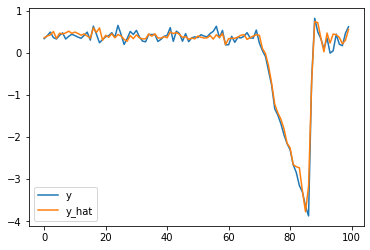

In [232]:
plot_velocity_curve(true=Y_test[n, :, 2].data.cpu().numpy(), pred=Y_hat[0, :, 2]) # z-velocity

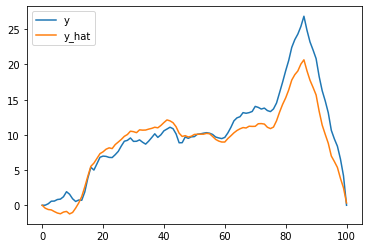

In [233]:
# POSITIONS
plot_position_curve(true=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat[0, :, 0])) # x-position

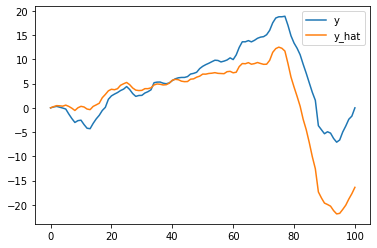

In [234]:
plot_position_curve(true=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat[0, :, 1])) # y-position

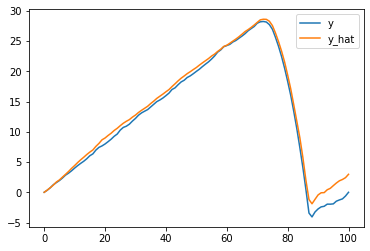

In [235]:
plot_position_curve(true=compute_position_from_velocity(Y_test[n, :, 2].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat[0, :, 2])) # z-position

In [236]:
# PREDICTION WITH UNCERTAINTY ESTIMATES

In [245]:
n = 80
samples=1000
result = vrnn.predict_with_uncertainty_vectorized(x=X_test[n:n+1, 0:1, :], A=A_test[n:n+1, :, :], Y=Y_test[n:n+1, :, :], samples=samples)
Y_hat_mean, Y_hat_std, Y_hat_lower, Y_hat_upper = result
# pos_mean, pos_std, pos_lower, pos_higher = position

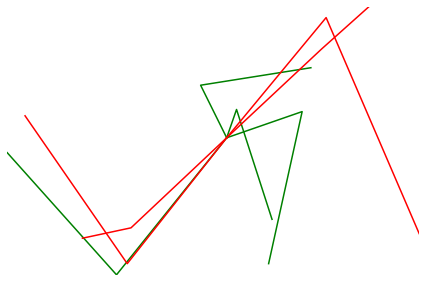

<Figure size 432x288 with 0 Axes>

In [217]:
compare_states(Y=Y_test[n], Y_hat=Y_hat_mean[0], overlap=True)            # animation of joints

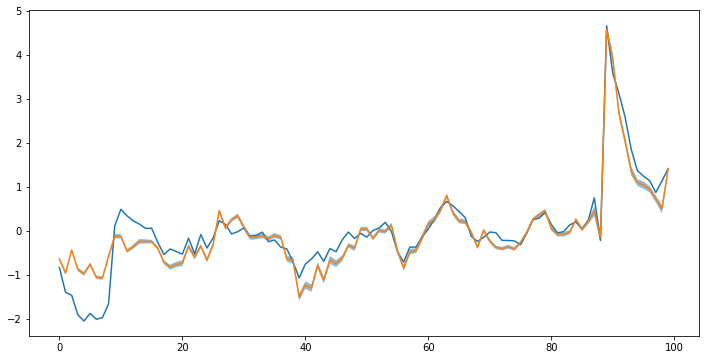

In [246]:
# VELOCITIES
i=0
plot_velocity_curve_with_uncertainty_shaded(true=Y_test[n, :, i].data.cpu().numpy(), pred=Y_hat_mean[0, :, i], error1=Y_hat_lower[0, :, i], error2=Y_hat_upper[0, :, i], axis=None) # x-velocity

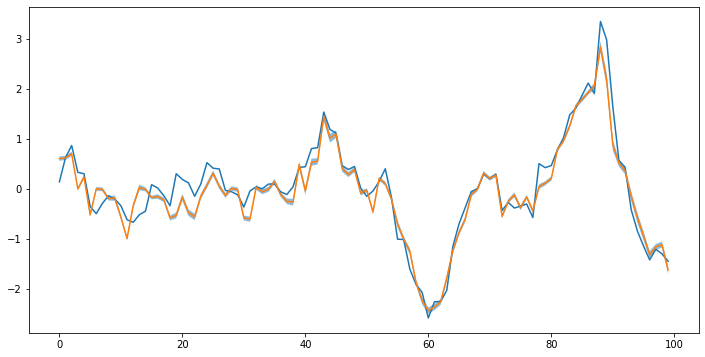

In [247]:
plot_velocity_curve_with_uncertainty_shaded(true=Y_test[n, :, 1].data.cpu().numpy(), pred=Y_hat_mean[0, :, 1], error1=Y_hat_lower[0, :, 1], error2=Y_hat_upper[0, :, 1], axis=None) # y-velocity

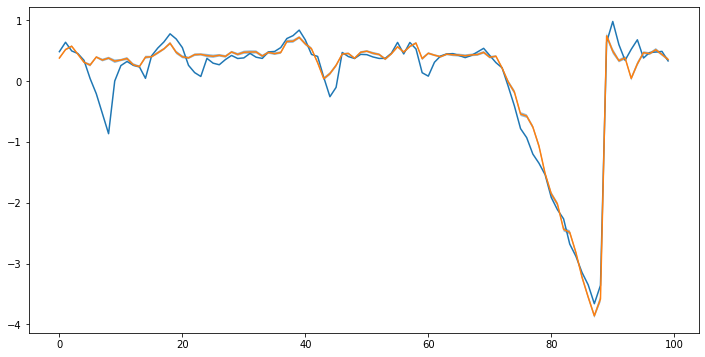

In [248]:
plot_velocity_curve_with_uncertainty_shaded(true=Y_test[n, :, 2].data.cpu().numpy(), pred=Y_hat_mean[0, :, 2], error1=Y_hat_lower[0, :, 2], error2=Y_hat_upper[0, :, 2], axis=None) # z-velocity

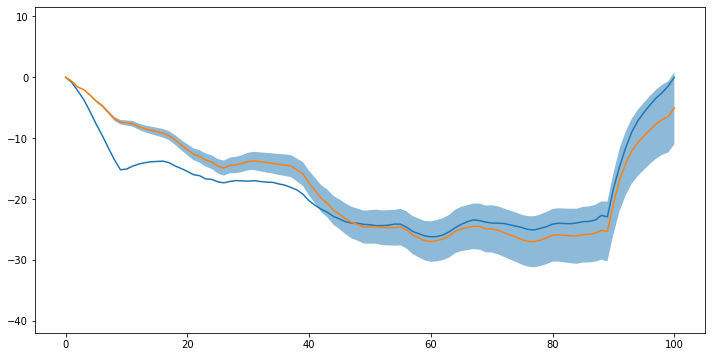

In [249]:
# POSITIONS
plot_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_test[n, :, 0].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat_mean[0, :, 0]), error1=compute_position_from_velocity(Y_hat_lower[0, :, 0]), error2=compute_position_from_velocity(Y_hat_upper[0, :, 0]), axis='equal') # x-position

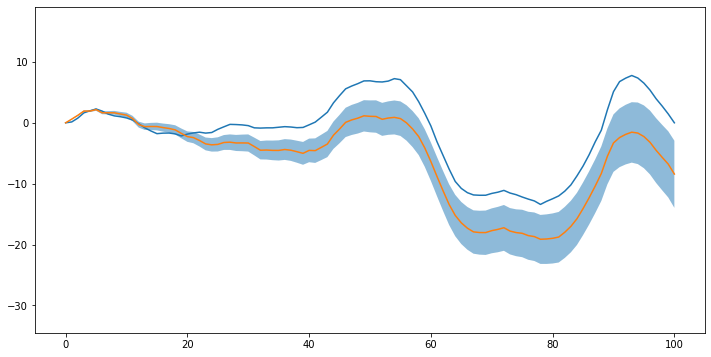

In [250]:
plot_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_test[n, :, 1].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat_mean[0, :, 1]), error1=compute_position_from_velocity(Y_hat_lower[0, :, 1]), error2=compute_position_from_velocity(Y_hat_upper[0, :, 1]), axis='equal') # y-position

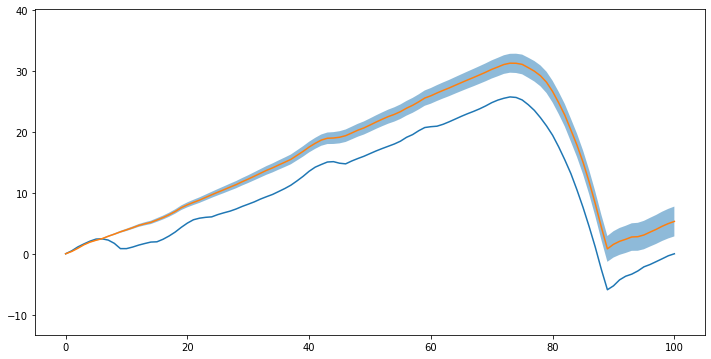

In [251]:
plot_position_curve_with_uncertainty_shaded(true=compute_position_from_velocity(Y_test[n, :, 2].data.cpu().numpy()), pred=compute_position_from_velocity(Y_hat_mean[0, :, 2]), error1=compute_position_from_velocity(Y_hat_lower[0, :, 2]), error2=compute_position_from_velocity(Y_hat_upper[0, :, 2]), axis='equal') # z-position